In [178]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader
from torchvision.models import ResNet50_Weights
import torch.nn.functional as F

from tqdm.notebook import tqdm
from PIL import Image

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
import numpy as np
import json
import random
import math
from sklearn.metrics.pairwise import cosine_similarity

import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

### Extracting image features

Designing an encoder layer with pretrained ResNet50, excluding the last year, the one which classifies

**ResNet50**

In [10]:
class EncoderCNN(nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-50 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        
        resnet = models.resnet50(weights = ResNet50_Weights.DEFAULT)
        self.resnet_layers = nn.Sequential(*list(resnet.children())[:-1]) #only keeping the part that extracts the features and not taking the part that classifies 

    def forward(self, images):
        """Extract feature vectors from input images."""

        with torch.no_grad():
            features = self.resnet_layers(images) #outputs feature map of shape (batchsize, 2048, 1, 1)
            features = features.view(features.size(0), -1) #flattens so it becomes (batchsize, 2048)
        return features

In [11]:
# instantiate encoder and put into evaluation mode
encoder = EncoderCNN()

encoder.eval()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\Dell/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

EncoderCNN(
  (resnet_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Co

**Image feature extraction**

In [133]:
data_transform = transforms.Compose([ 
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    #transforms.CenterCrop(224), 
    transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms
                         (0.229, 0.224, 0.225))])

Resizing to lower pixels so that the model trains faster, and doesn't affect the accuracy much

In [13]:
# Get unique images from the csv for extracting features
imageList = pd.read_csv("coco_subset_meta.csv")
imageList['file_name']
len(imageList.id.unique())

imagesUnique = sorted(imageList['file_name'].unique())
print(len(imagesUnique))

df_unique_files =  pd.DataFrame.from_dict(imagesUnique)

df_unique_files.columns = ['file_name']
df_unique_files

5068


,file_name
0,000000000009.jpg
1,000000000025.jpg
2,000000000030.jpg
3,000000000034.jpg
4,000000000036.jpg
...,...
5063,000000581906.jpg
5064,000000581909.jpg
5065,000000581913.jpg
5066,000000581921.jpg


In [14]:
# Define a class COCOImagesDataset(Dataset) function that takes the 
# image file names and reads the image and apply transform to it
IMAGE_DIR = "coco/images/"

class COCOImagesDataset(Dataset):
    def __init__(self, df, transform = None):

        self.df = df
        self.transform = transform

    def __getitem__(self, index):
        filename = self.df.iloc[index]["file_name"]
        img_id = os.path.splitext(filename)[0]
        
        # load image using PIL and apply transform
        img_path = os.path.join(IMAGE_DIR, filename)
        img = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)               
        
        return img, img_id       

    def __len__(self):
        return len(self.df)

In [134]:
# Dataloader to use the unique files using the class COCOImagesDataset
# shuffle is False as we are not aiming to retrain in this exercise
dataset = COCOImagesDataset(df_unique_files, transform = data_transform)
dataloader = DataLoader(dataset, batch_size = 64, shuffle = False)

In [135]:
# Apply encoder to extract featues and saving them
features_map = dict()
 
with torch.no_grad():
    for images, filenames in tqdm(dataloader):
        features = encoder(images)
        for i in range(len(filenames)):
            filename = filenames[i]
            feature = features[i]
            features_map[filename] = feature.numpy()
    torch.save(features_map, 'image_features.pt')

  0%|          | 0/80 [00:00<?, ?it/s]

In [136]:
feat_saved = torch.load("image_features.pt")

**Text preparation**

Building the caption dataset

In [19]:
# loading captions for training
with open('coco/annotations2017/captions_train2017.json', 'r') as json_file:
    data = json.load(json_file)
    
df_captions = pd.DataFrame.from_dict(data["annotations"])
df_captions.head()

,image_id,id,caption
0,203564,37,A bicycle replica with a clock as the front wh...
1,322141,49,A room with blue walls and a white sink and door.
2,16977,89,A car that seems to be parked illegally behind...
3,106140,98,A large passenger airplane flying through the ...
4,106140,101,There is a GOL plane taking off in a partly cl...


In [20]:
df_captions.shape

(591753, 3)

In [22]:
# df_captions[df_captions["image_id"] == 262146]

In [23]:
df_new_captions = df_captions.copy()
df_new_captions = df_new_captions.rename(columns={'id': 'ID'})
df_new_captions = df_new_captions.rename(columns={'image_id': 'id'})
df_new_captions.head()

,id,ID,caption
0,203564,37,A bicycle replica with a clock as the front wh...
1,322141,49,A room with blue walls and a white sink and door.
2,16977,89,A car that seems to be parked illegally behind...
3,106140,98,A large passenger airplane flying through the ...
4,106140,101,There is a GOL plane taking off in a partly cl...


In [24]:
df_new_captions.shape

(591753, 3)

In [25]:
coco_subset = pd.read_csv("coco_subset_meta.csv")

In [26]:
coco_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     8000 non-null   int64 
 1   license        8000 non-null   int64 
 2   file_name      8000 non-null   object
 3   coco_url       8000 non-null   object
 4   height         8000 non-null   int64 
 5   width          8000 non-null   int64 
 6   date_captured  8000 non-null   object
 7   flickr_url     8000 non-null   object
 8   id             8000 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 562.6+ KB


In [27]:
coco_subset.shape

(8000, 9)

In [28]:
coco_subset.head()

,Unnamed: 0,license,file_name,coco_url,height,width,date_captured,flickr_url,id
0,0,2,000000262145.jpg,http://images.cocodataset.org/train2017/000000...,427,640,2013-11-20 02:07:55,http://farm8.staticflickr.com/7187/6967031859_...,262145
1,1,1,000000262146.jpg,http://images.cocodataset.org/train2017/000000...,640,480,2013-11-19 23:07:16,http://farm6.staticflickr.com/5090/5341741494_...,262146
2,2,3,000000524291.jpg,http://images.cocodataset.org/train2017/000000...,426,640,2013-11-18 09:59:07,http://farm2.staticflickr.com/1045/934293170_d...,524291
3,3,1,000000262148.jpg,http://images.cocodataset.org/train2017/000000...,512,640,2013-11-20 05:50:03,http://farm5.staticflickr.com/4028/4549977479_...,262148
4,4,3,000000393223.jpg,http://images.cocodataset.org/train2017/000000...,480,640,2013-11-21 20:08:57,http://farm1.staticflickr.com/28/45521803_c5cb...,393223


In [29]:
new_coco = coco_subset.copy()
new_coco = new_coco.drop_duplicates(subset = "id")
new_coco.head()

,Unnamed: 0,license,file_name,coco_url,height,width,date_captured,flickr_url,id
0,0,2,000000262145.jpg,http://images.cocodataset.org/train2017/000000...,427,640,2013-11-20 02:07:55,http://farm8.staticflickr.com/7187/6967031859_...,262145
1,1,1,000000262146.jpg,http://images.cocodataset.org/train2017/000000...,640,480,2013-11-19 23:07:16,http://farm6.staticflickr.com/5090/5341741494_...,262146
2,2,3,000000524291.jpg,http://images.cocodataset.org/train2017/000000...,426,640,2013-11-18 09:59:07,http://farm2.staticflickr.com/1045/934293170_d...,524291
3,3,1,000000262148.jpg,http://images.cocodataset.org/train2017/000000...,512,640,2013-11-20 05:50:03,http://farm5.staticflickr.com/4028/4549977479_...,262148
4,4,3,000000393223.jpg,http://images.cocodataset.org/train2017/000000...,480,640,2013-11-21 20:08:57,http://farm1.staticflickr.com/28/45521803_c5cb...,393223


In [30]:
new_file = pd.merge(new_coco, df_new_captions, on ='id')

In [31]:
new_file.head()

,Unnamed: 0,license,file_name,coco_url,height,width,date_captured,flickr_url,id,ID,caption
0,0,2,000000262145.jpg,http://images.cocodataset.org/train2017/000000...,427,640,2013-11-20 02:07:55,http://farm8.staticflickr.com/7187/6967031859_...,262145,694,People shopping in an open market for vegetables.
1,0,2,000000262145.jpg,http://images.cocodataset.org/train2017/000000...,427,640,2013-11-20 02:07:55,http://farm8.staticflickr.com/7187/6967031859_...,262145,1054,An open market full of people and piles of veg...
2,0,2,000000262145.jpg,http://images.cocodataset.org/train2017/000000...,427,640,2013-11-20 02:07:55,http://farm8.staticflickr.com/7187/6967031859_...,262145,1456,People are shopping at an open air produce mar...
3,0,2,000000262145.jpg,http://images.cocodataset.org/train2017/000000...,427,640,2013-11-20 02:07:55,http://farm8.staticflickr.com/7187/6967031859_...,262145,5248,Large piles of carrots and potatoes at a crowd...
4,0,2,000000262145.jpg,http://images.cocodataset.org/train2017/000000...,427,640,2013-11-20 02:07:55,http://farm8.staticflickr.com/7187/6967031859_...,262145,5254,People shop for vegetables like carrots and po...


In [32]:
new_file = new_file.drop(["license","coco_url", "height", "width", "date_captured", "flickr_url", "Unnamed: 0"], axis = 1)

In [33]:
new_file = new_file.rename(columns={'ID': 'image_id'})

In [34]:
new_file.head()

,file_name,id,image_id,caption
0,000000262145.jpg,262145,694,People shopping in an open market for vegetables.
1,000000262145.jpg,262145,1054,An open market full of people and piles of veg...
2,000000262145.jpg,262145,1456,People are shopping at an open air produce mar...
3,000000262145.jpg,262145,5248,Large piles of carrots and potatoes at a crowd...
4,000000262145.jpg,262145,5254,People shop for vegetables like carrots and po...


In [35]:
new_file.shape

(25349, 4)

Clean the captions

In [36]:
new_file['clean_caption'] = '' # add a new column to the dataframe for the cleaned captions

def gen_clean_captions_df(df):
    for idx in df.index:
        caption = df.loc[idx]['caption']
        
        # Remove spaces in the beginning and at the end
        caption = caption.strip()
        
        # Convert to lower case
        caption = caption.lower()

        # Replace all non-alphabet characters with space
        caption = ''.join(c if c.isalpha() else ' ' for c in caption)

        # Replace all continuous spaces with a single space
        caption = ' '.join(caption.split())
        
        df.loc[idx, 'clean_caption'] = caption

    return df

In [37]:
new_file = gen_clean_captions_df(new_file)
new_file.head(10)

,file_name,id,image_id,caption,clean_caption
0,000000262145.jpg,262145,694,People shopping in an open market for vegetables.,people shopping in an open market for vegetables
1,000000262145.jpg,262145,1054,An open market full of people and piles of veg...,an open market full of people and piles of veg...
2,000000262145.jpg,262145,1456,People are shopping at an open air produce mar...,people are shopping at an open air produce market
3,000000262145.jpg,262145,5248,Large piles of carrots and potatoes at a crowd...,large piles of carrots and potatoes at a crowd...
4,000000262145.jpg,262145,5254,People shop for vegetables like carrots and po...,people shop for vegetables like carrots and po...
5,000000262146.jpg,262146,634780,a person skiing down a steep hill,a person skiing down a steep hill
6,000000262146.jpg,262146,637393,A person skiing down a steep snowy hill.,a person skiing down a steep snowy hill
7,000000262146.jpg,262146,640348,A person on snow skis going down a steep slope.,a person on snow skis going down a steep slope
8,000000262146.jpg,262146,641836,A skier is skiing down a down hill slope.,a skier is skiing down a down hill slope
9,000000262146.jpg,262146,649789,A skier is shown taking on a very steep slope.,a skier is shown taking on a very steep slope


In [38]:
new_file = new_file.rename(columns={'id': 'the_other'})
new_file = new_file.rename(columns={'image_id': 'the_another'})

In [39]:
new_file = new_file.rename(columns={'the_other': 'image_id'})
new_file = new_file.rename(columns={'the_another': 'id'})
new_file.head()

,file_name,image_id,id,caption,clean_caption
0,000000262145.jpg,262145,694,People shopping in an open market for vegetables.,people shopping in an open market for vegetables
1,000000262145.jpg,262145,1054,An open market full of people and piles of veg...,an open market full of people and piles of veg...
2,000000262145.jpg,262145,1456,People are shopping at an open air produce mar...,people are shopping at an open air produce market
3,000000262145.jpg,262145,5248,Large piles of carrots and potatoes at a crowd...,large piles of carrots and potatoes at a crowd...
4,000000262145.jpg,262145,5254,People shop for vegetables like carrots and po...,people shop for vegetables like carrots and po...


**Spliting the data** 

In [41]:
unique_image_id = list(new_file["image_id"].unique())

In [42]:
len(unique_image_id)

5068

In [43]:
def split_ids(image_id_list, train = 0.7, valid = 0.1, test = 0.2):
    """
    Args:
        image_id_list (int list): list of unique image ids
        train (float): train split size (between 0 - 1)
        valid (float): valid split size (between 0 - 1)
        test (float): test split size (between 0 - 1)
    """
    list_copy = image_id_list.copy()
    random.shuffle(list_copy)
    
    train_size = math.floor(len(list_copy) * train)
    valid_size = math.floor(len(list_copy) * valid)
    
    return list_copy[:train_size], list_copy[train_size:(train_size + valid_size)], list_copy[(train_size + valid_size):]

In [44]:
train_set, validation_set, test_set = split_ids(unique_image_id)

In [45]:
len(train_set)

3547

In [46]:
#the training set with unique image_ids
train_df = new_file[new_file['image_id'].isin(train_set)].reset_index(drop = True)

In [47]:
len(train_df)

17740

In [48]:
#the validation set with unique image_ids
val_df = new_file[new_file['image_id'].isin(validation_set)].reset_index(drop = True)

In [49]:
#the test set with unique image_ids
test_df = new_file[new_file['image_id'].isin(test_set)].reset_index(drop = True)

In [50]:
train_df.shape

(17740, 5)

In [51]:
val_df.shape

(2531, 5)

In [52]:
test_df.shape

(5078, 5)

In [53]:
#a list of all the unique ids in training and validation
comb = train_set + validation_set

In [54]:
#combining the training and the validation to get all the vocab
comb_set = pd.concat([train_df["image_id"], val_df["image_id"]], ignore_index = True)

In [55]:
comb_d = pd.concat([train_df, val_df], ignore_index=True)

In [56]:
comb_d.shape

(20271, 5)

**Building the vocabulary**

In [57]:
class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # intially, set both the IDs and words to dictionaries with special tokens
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<end>': 2}
        self.idx2word = {0: '<pad>', 1: '<unk>', 2: '<end>'}
        self.idx = 3

    def add_word(self, word):
        # if the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            # this will convert each word to index and index to word 
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # if we try to access a word not in the dictionary, return the id for <unk>
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [67]:
MIN_FREQUENCY = 3 #so we don't keep words that don't contribute much

import re

def build_vocab(df_ids, new_file):
    """ 
    Parses training set token file captions and builds a Vocabulary object and dataframe for 
    the image and caption data

    Returns:
        vocab (Vocabulary): Vocabulary object containing all words appearing more than min_frequency
    """
    word_mapping = Counter()

    for Id in df_ids:
        rows = new_file.loc[new_file['image_id'] == Id]['clean_caption']
        for i in range(len(rows)):
            caption = rows.iloc[i]
            for word in caption.split():
                # already removed non-alphabetic characters and convert to lowercase
                #word = re.sub(r'[^a-zA-Z]', ' ', word.lower())
                
                # Add the word to the counter
                word_mapping[word] += 1

    # create a vocab instance
    vocab = Vocabulary()

    # add the words to the vocabulary
    for word in word_mapping:
        # Ignore infrequent words to reduce the embedding size
        if word_mapping[word] > MIN_FREQUENCY:
            vocab.add_word(word)
    return vocab

In [68]:
#building the vocab for  training and validation
the_vocab = build_vocab(comb, new_file)

In [69]:
#building the test vocab
test_vocab = build_vocab(test_set, new_file)

In [70]:
print(len(the_vocab))
print(len(test_vocab))

2430
1110


**Preparing dataset using dataloader**

In [71]:
MAX_SEQ_LEN = 47

class COCO_Features(Dataset):
    """ COCO subset custom dataset, compatible with torch.utils.data.DataLoader. """
    
    def __init__(self, df, features, vocab):
        """
        Args:
            df: (dataframe or some other data structure/s you may prefer to use)
            features: image features
            vocab: vocabulary wrapper
           
        """
        self.df = df
        self.features = features
        self.vocab = vocab
    
    def __getitem__(self, index):
        """ Returns one data tuple (feature [1, 2048], target caption of word IDs [1, 47], and integer true caption length) """   
        
        img_id = self.df.iloc[index]["file_name"] #retrieves the filename at that index
        
        filename_without_ex = os.path.splitext(img_id)[0] #extracts the base file name without the jpg extension
        caption = self.df.iloc[index]["clean_caption"] #returns the cleaned caption at that index
    
        tokens = nltk.tokenize.word_tokenize(str(caption).lower()) #tokenizes the caption 
        caption_ids = [self.vocab.word2idx.get(word, self.vocab.word2idx["<unk>"]) for word in tokens] #converts the tokens into word ids using the vocab fn, unk means unknown id
        caption_ids.append(self.vocab.word2idx["<end>"]) #adds end tokens
        caption_ids = torch.LongTensor(caption_ids[:MAX_SEQ_LEN] + [self.vocab.word2idx["<pad>"]] * (MAX_SEQ_LEN - len(caption_ids))) #adds padding to the captions so that theyre of the same length
        caption_length = len(caption_ids.nonzero()) #calculates the length of the caption without the padding
       
        features = torch.from_numpy(self.features[filename_without_ex]) #retrieves the features that correspond
        
        return features, caption_ids, torch.tensor(caption_length) 
    
    def __len__(self):
        return len(self.df)

In [72]:
def caption_collate_fn(batch):
    """ Collate function for DataLoader """
    # Get the list of image features and target captions
    batch.sort(key = lambda x: x[2], reverse = True)
    
    images = [item[0] for item in batch]  # list of images
    captions = [item[1] for item in batch]  # list of captions
    
    # Pad the captions to have the same length
    padded_captions = torch.nn.utils.rnn.pad_sequence(captions, batch_first = True, padding_value = 0)
    
    # Compute the length of each caption
    lengths = torch.tensor([len(caption) for caption in captions])
    
    return torch.stack(images), padded_captions, lengths

In [137]:
dataset_train = COCO_Features(
    df = train_df,
    vocab = the_vocab,
    features = feat_saved,
)

train_loader = DataLoader(
    dataset = dataset_train,
    batch_size = 128,
    shuffle = True,
    collate_fn = caption_collate_fn
)


dataset_valid = COCO_Features(
    df = val_df,
    vocab = the_vocab,
    features = feat_saved,
)

valid_loader = DataLoader(
    dataset = dataset_valid,
    batch_size = 128,
    shuffle = False,
    collate_fn = caption_collate_fn 
)

In [138]:
for i, batch in enumerate(train_loader):
    images, targets, lengths = batch
    print(f"Batch {i}")
    print(f"Images shape: {images.shape}")
    print(f"Targets shape: {targets.shape}")
    print(f"Lengths: {lengths}")
    break

Batch 0
Images shape: torch.Size([128, 2048])
Targets shape: torch.Size([128, 47])
Lengths: tensor([47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47,
        47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47,
        47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47,
        47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47,
        47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47,
        47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47,
        47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47,
        47, 47])


**Training DecoderRNN**

In [203]:
class DecoderRNN(nn.Module):
    
    def __init__(self, vocab_size, embed_size = 128, hidden_size = 256, num_layers = 1, max_seq_length = 47):
        
        """Set the hyper-parameters and build the layers."""
        
        super(DecoderRNN, self).__init__()
        # we want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last convolutional layer (flattened to dimensions after AdaptiveAvgPool2d that may give
        # you => 1 x 1 x 2048, other layers are also accepted but this will affect your accuracy!) into a Linear layer to resize
        self.resize = nn.Linear(2048, embed_size)
        # batch normalisation helps to speed up training
        self.bn = nn.BatchNorm1d(embed_size, momentum = 0.01)

        self.embed = nn.Embedding(vocab_size, embed_size)


        self.rnn = nn.LSTM(embed_size, hidden_size, num_layers, batch_first = True)
   
        # self.linear: linear layer with input: hidden layer, output: vocab size
        self.linear = nn.Linear(hidden_size, vocab_size)

        self.max_seq_length = max_seq_length
        

    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        
        embeddings = self.embed(captions)
        
        im_features = self.resize(features)
        
        im_features = self.bn(im_features)
        
        # compute feature embeddings
        inputs = torch.cat((im_features.unsqueeze(1), embeddings), dim = 1)
        
        packed = pack_padded_sequence(inputs, lengths, batch_first = True, enforce_sorted = False)
        
        hiddens, _ = self.rnn(packed)
        
        #outputs, _ = pad_packed_sequence(hiddens, batch_first = True)
        
        
        # pack_padded_sequence returns a PackedSequence object, which contains two items: 
        # the packed data (data cut off at its true length and flattened into one list), and 
        # the batch_sizes, or the number of elements at each sequence step in the batch.
        # For instance, given data [a, b, c] and [x] the PackedSequence would contain data 
        # [a, x, b, c] with batch_sizes=[2,1,1].

        outputs = self.linear(hiddens[0]) 
        
        # Reshape from (batch_size, max_seq_length, hidden_size) to (batch_size * max_seq_length, hidden_size)
        #outputs = outputs.reshape(-1, outputs.shape[2])
        
        #outputs = self.linear(outputs)
        
        return outputs
    
    
    def sample(self, features, states = None):
        """Generate captions for given image features using greedy search."""
        
        sampled_ids = []

        inputs = self.bn(self.resize(features)).unsqueeze(1)
        
        for i in range(self.max_seq_length):
            
            hiddens, states = self.rnn(inputs, states)  # hiddens: (batch_size, 1, hidden_size)
            
            outputs = self.linear(hiddens.squeeze(1))   # outputs:  (batch_size, vocab_size)
            
            _, predicted = outputs.max(1)               # predicted: (batch_size)
            
            sampled_ids.append(predicted)
            
            inputs = self.embed(predicted)              # inputs: (batch_size, embed_size)
            
            inputs = inputs.unsqueeze(1)                # inputs: (batch_size, 1, embed_size)
        
        sampled_ids = torch.stack(sampled_ids, 1)       # sampled_ids: (batch_size, max_seq_length)
        
        return sampled_ids

In [204]:
# instantiate decoder
decoder = DecoderRNN( vocab_size = len(the_vocab))
criteriond = nn.CrossEntropyLoss()
params = list(decoder.parameters())
optimizerd = torch.optim.Adam(params, lr = 0.001) #good results with this learning rate
train_losses = []
valid_losses = []

Used lower embedding and hidden size so that it's not computationally heavy (similar results with higher embedding and hidden size)

In [205]:
decoder 

DecoderRNN(
  (resize): Linear(in_features=2048, out_features=128, bias=True)
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (embed): Embedding(2430, 128)
  (rnn): LSTM(128, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=2430, bias=True)
)

**Trainining**

Epoch [1], Training Loss: 0.74, Training Accuracy: 85.45% Validation Loss: 0.78, Validation Accuracy: 85.07%
Epoch [2], Training Loss: 0.69, Training Accuracy: 85.96% Validation Loss: 0.76, Validation Accuracy: 85.34%
Epoch [3], Training Loss: 0.65, Training Accuracy: 86.40% Validation Loss: 0.75, Validation Accuracy: 85.35%
Epoch [4], Training Loss: 0.62, Training Accuracy: 86.81% Validation Loss: 0.74, Validation Accuracy: 85.43%
Epoch [5], Training Loss: 0.59, Training Accuracy: 87.18% Validation Loss: 0.74, Validation Accuracy: 85.54%
Epoch [6], Training Loss: 0.56, Training Accuracy: 87.55% Validation Loss: 0.74, Validation Accuracy: 85.50%
Epoch [7], Training Loss: 0.54, Training Accuracy: 87.87% Validation Loss: 0.74, Validation Accuracy: 85.53%
Epoch [8], Training Loss: 0.52, Training Accuracy: 88.17% Validation Loss: 0.74, Validation Accuracy: 85.51%
Epoch [9], Training Loss: 0.50, Training Accuracy: 88.49% Validation Loss: 0.74, Validation Accuracy: 85.43%
Epoch [10], Trainin

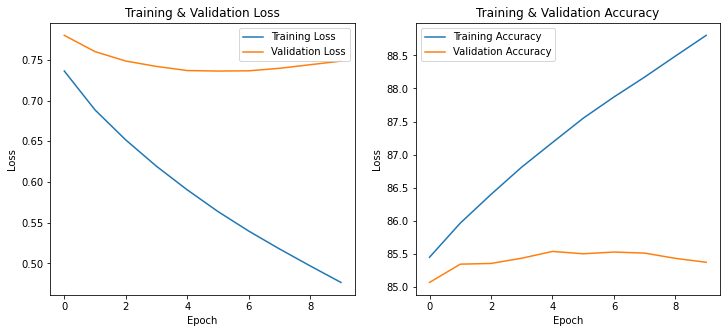

In [159]:
#used this loop to train the model and generate predictions 
epochs = 10 
criterion = nn.CrossEntropyLoss()

params = list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr = 0.001)

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(epochs):
    decoder.train()
    
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    for i, (features, captions, lengths) in enumerate(train_loader):
        
        optimizer.zero_grad()
        
        outputs = decoder(features, captions,lengths)
        
        packed_targets = pack_padded_sequence(captions, lengths, batch_first = True)[0]
        
        loss = criterion(outputs, packed_targets)
        
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
        
        predicted = outputs.argmax(dim = 1)  # Get the word with the highest probability
        train_correct += (predicted == packed_targets).sum().item()
        train_total += packed_targets.numel()  # Total words in batch

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = train_correct / train_total * 100 
    train_accuracies.append(train_accuracy)
    
    decoder.eval()
    
    valid_loss = 0
    valid_correct = 0
    valid_total = 0
    
    with torch.no_grad():
        for i, (features, captions, lengths) in enumerate(valid_loader):
            
            outputs = decoder(features, captions,lengths)
            
            packed_targets = pack_padded_sequence(captions, lengths, batch_first = True)[0]
            
            loss = criterion(outputs, packed_targets)
            
            valid_loss += loss.item()
            
            predicted = outputs.argmax(dim = 1)
            valid_correct += (predicted == packed_targets).sum().item()
            valid_total += packed_targets.numel()
    
    valid_loss /= len(valid_loader)
    valid_losses.append(valid_loss)
    valid_accuracy = valid_correct / valid_total * 100 
    valid_accuracies.append(valid_accuracy)
    
    print("Epoch [{}], Training Loss: {:.2f}, Training Accuracy: {:.2f}%, Validation Loss: {:.2f}, Validation Accuracy: {:.2f}%".format(epoch + 1, train_loss, train_accuracy, valid_loss, valid_accuracy))

  
plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label = "Training Loss")
plt.plot(valid_losses, label = "Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label = "Training Accuracy")
plt.plot(valid_accuracies, label = "Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Accuracy")

plt.show()

So as we can see the training loss kept going down after each epoch and the training accuracy kept going up, but the validation loss stopped going down after the 5th epoch and went up on the 10th epoch and the validation accuracy went down after the 5th epoch.

So the best results were at the 5th epoch, with a training loss of 0.59 and validation loss of 0.74 and training accuracy of 87.18% and validation accuracy of 85.54%

In [160]:
#was no need to do 10 loops, validation accuracy peaks at the 5th epoch
torch.save(decoder.state_dict(), "decoder.pth")  

**Predictions on random images**

In [161]:
model_load = DecoderRNN(vocab_size = len(the_vocab))
model_load.load_state_dict(torch.load("decoder.pth"))

<All keys matched successfully>

Generated Caption: a <unk> of a person that is sitting on a bench


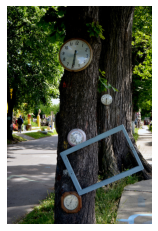

Reference captions:
** A tree covered with clocks next to a sidewalk.
** A lot of clocks that are on a tree.
** An art project consisting of clocks nailed to a tree
** A tree with several clocks and an empty picture frame on it.
** Various clocks and a picture frame hanging on a tree.


Generated Caption: a bathroom with a toilet and a sink


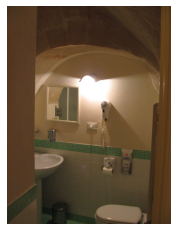

Reference captions:
** A bathroom with white and green tiled walls 
** an image of bathroom setting with white toilet
** The light shines brightly in a small bathroom.
** A bathroom with a hair dryer above the toilet, and a sink with a mirror above it.
** a bathroom with a toilet a sink and a small mirror


Generated Caption: a giraffe standing next to a giraffe in a zoo enclosure


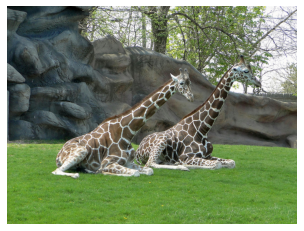

Reference captions:
** Two giraffe laying in a open grassy field.
** Two giraffe sitting on the ground next to each other in a field.
** two giraffes sitting on the grass outside of a stone enclosure.
** Two giraffe laying down in the grass next to a stone wall.
** TWO GIRAFFES SITTING IN THE EXACT SAME POSITION


Generated Caption: a man in a shirt and tie playing a video game


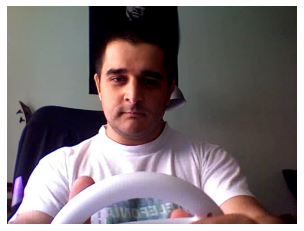

Reference captions:
** A man in a white t-shirt holding a white toy steering wheel
** A man with a steering wheel remote control in his hands.
** A man is holding a video game steering wheel.
** A man sitting in a room with a poster on the wall.
** A man holding a Nintendo Wii game controller.


Generated Caption: a large desk with a laptop computer and a monitor


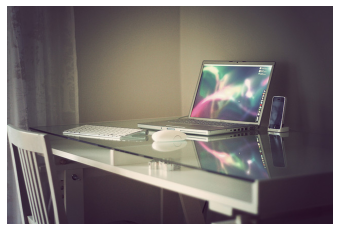

Reference captions:
** A modern glass desk with a laptop and docked smartphone.
** a glass top desk with a laptop open on it
** The desk has a glass top on it.
** A laptop with a phone sits on a desk.
** A laptop with a colorful screen is sitting on a glass top desk.




In [163]:
#taking 5 random images
images_path = test_df["file_name"].tolist()
selected_img_pth = random.sample(images_path, 5)

#generating captions
model_load.eval()

for img in selected_img_pth:
    
    image = Image.open(IMAGE_DIR + img)
    
    img_id = os.path.splitext(img)[0]
    
    images_feature = torch.from_numpy(feat_saved[img_id]).unsqueeze(0)
    
    generated_caption = model_load.sample(images_feature, states = None)
    generated_caption = generated_caption[0].cpu().numpy()
    
    sample_captions = []
    
    for wordid in generated_caption:
        word = the_vocab.idx2word[wordid]
        if word == "<end>":
            break
        sample_captions.append(word)
        
    final_caption = " ".join(sample_captions)
    
    print("Generated Caption: {}".format(final_caption))
    # display image and captions
    plt.imshow(image)
    plt.axis("off")
    plt.show()

    reference_caption = test_df[test_df["file_name"] == img]["caption"].tolist()
    print("Reference captions:")
    for caption in reference_caption:
        print("** " + caption)
    print("\n")

Generated Caption: a person on a snowboard in the snow


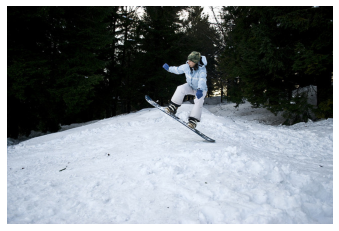

Reference captions:
** a person jumping a snow board in the air
** A boy skating on the snow covered mountain
** A person that is out in the snow in the air.
** A person doing jump on snowboard on snow covered slope.
** a person riding a snowboard on top of a snow covered slope.


Generated Caption: a person riding a bike on a city street


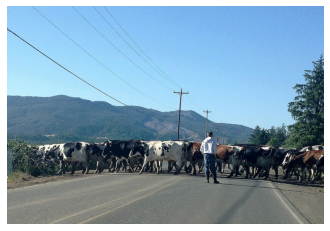

Reference captions:
** a number of cows  walking across a road
** A herd of cattle crossing a street while a man stands in the middle of the road.
** A man in grey sweater watching cows cross a road.
** A man watches as a herd of cattle cross the road.
** Herd of cattle crossing road with adult standing and blue sky


Generated Caption: a <unk> <unk> with a <unk> <unk>


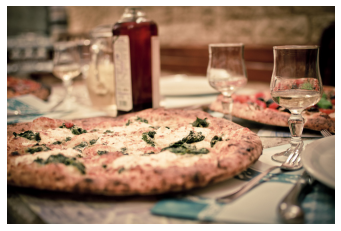

Reference captions:
** Pizzas sitting on a table next to a bottle of wine.
** A table is set with three rustic pizza pies.
** A table with two different pizzas on it.
** a table covered with 3 pizzas, wine glasses and silverware
** A table is set with a pizza and glasses on it.


Generated Caption: a vase of flowers and a red flowers


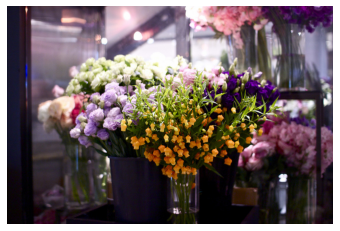

Reference captions:
** A lot of vases filled with lots of flowers.
** Several vases filled with different kinds of flowers.
** a lot of  colorful flowers in vases
** Floral arrangements displayed in floral shop in glass vases.
** Several vases with flower arrangements sitting on a table 


Generated Caption: a young child is riding a wave in the ocean


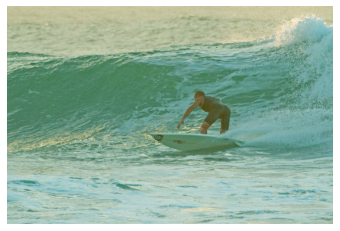

Reference captions:
** A man surfboarding in a rough ocean with waves
** A surfer shredding the gnar, about to catch a wave
** A person riding a surf board on the ocean.
** A man riding a surfboard on a wave in the ocean.
** Male surfer riding a large wave with sun low in the sky




In [164]:
image_paths = test_df["file_name"].tolist()
num_photos = 5
selected_img_pth = random.sample(image_paths, num_photos)

model_load.eval()

# display images and captions
for image_path in selected_img_pth:
    # load image and extract features
    
    image = Image.open(IMAGE_DIR + image_path)
    
    img_id = os.path.splitext(image_path)[0]
    
    images_features = torch.from_numpy(feat_saved[img_id]).unsqueeze(0)


    # generate caption
    generated_caption = model_load.sample(images_features)
    generated_caption = generated_caption[0].cpu().numpy()
    
    sampled_caption = []
    for word_id in generated_caption:
        word = the_vocab.idx2word[word_id]
        if word == "<end>":
            break
        sampled_caption.append(word)
        
    final_caption = " ".join(sampled_caption)
    
    # display generated caption
    print("Generated Caption: {}".format(final_caption))
    # display image and captions
    plt.imshow(image)
    plt.axis("off")
    plt.show()

    reference_captions = test_df[test_df["file_name"] == image_path]["caption"].tolist()
    print("Reference captions:")
    for caption in reference_captions:
        print("** " + caption)
    print("\n")
#checking if it does in fact work

So as we can see the model generates good results on two different batch of images

**Evalutaion using the test data**

Caption evaluation using BLEU score

In [165]:
test_dataset = COCO_Features(test_df, feat_saved, the_vocab)

# create the data loader for the test dataset
test_loader = DataLoader(dataset = test_dataset, batch_size = 1, shuffle = False, collate_fn = caption_collate_fn)

In [166]:
smoothing_fn = SmoothingFunction().method1

stats_bleu = pd.DataFrame(columns = ['ref','preds','bleu','cos_sim'])


for i, (image, caption, length) in enumerate(test_loader):
    
    images_path = test_df["file_name"].tolist()
    
    img_path = images_path[i]
    
    caption_generated = model_load.sample(image)
    
    caption_generated = caption_generated[0].cpu().numpy()
    
    sample_caption = []
    
    for word_id in caption_generated:
        
        word = the_vocab.idx2word[word_id]
        
        if word == "<end>":
            
            break
        
        sample_caption.append(word)
        
    final_caption = " ".join(sample_caption)
    
    reference_captions = test_df[test_df["file_name"] == img_path]["caption"].tolist()
    
    ref_cap = [caption.split() for caption in reference_captions]
    
    bleu_score = sentence_bleu(ref_cap, final_caption.split(), weights = (1, 0, 0, 0), smoothing_function = smoothing_fn)

    stats_bleu = stats_bleu._append({"ref": reference_captions, "preds": final_caption, "bleu": bleu_score}, ignore_index = True)

Average BLEU score: 0.5361574866473633


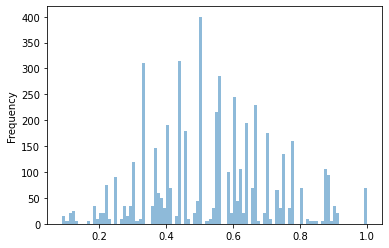

In [167]:
print("Average BLEU score:", stats_bleu['bleu'].mean())
ax = stats_bleu['bleu'].plot.hist(bins = 100, alpha = 0.5)

So we get an average BLEU score of 0.5361, which suggests a reasonable level of similarity to the reference translation. The model can tweaked further to get a higher score around 0.7, which would suggest a high level of similarity and the resulting generated captions would be much better

Example high and low score BLEU score sample

In [168]:
max_index = stats_bleu["bleu"].idxmax()
min_index = stats_bleu["bleu"].idxmin()


print("Sample with highest BLEU score:")
print("Predicted sentence:", stats_bleu["preds"][max_index]) #predicted caption
print("BLEU score:", stats_bleu["bleu"][max_index]) #BLEU score
print("Reference captions:") #the reference captions
for i in range(5):
    print(stats_bleu["ref"][max_index][i])
print()


print("Sample with lowest BLEU score:")
print("Predicted sentence:", stats_bleu["preds"][min_index]) #predicted caption
print("BLEU score:", stats_bleu["bleu"][min_index]) #BLEU score
print("Reference captions:") #the reference captions
for i in range(5):
    print(stats_bleu["ref"][min_index][i])

Sample with highest BLEU score:
Predicted sentence: a computer desk with a laptop and a monitor
BLEU score: 1.0
Reference captions:
A cat lying under a laptop and beside another computer. 
there is a computer and a lap top on a desk and a cat sitting behind it
a desk with a laptop a monitor and a mouse
A cat that is sitting by two computers.
a gray black and white cat a monitor and a laptop and keyboard

Sample with lowest BLEU score:
Predicted sentence: a <unk> <unk> <unk> <unk> <unk> from a <unk> <unk>
BLEU score: 0.09048374180359597
Reference captions:
Some shirtless guys hanging around near each other.
three men wearing no shirts standing around, one looking at his phone
Three shirtless men standing near each other with palm trees in the background.
few guys hanging out together on the sidewalk
a group of men stand by some booths selling some items 


As we can see the caption with the highest BLEU score has a score of 1.0, which indicates that it contains all the words in the refernece captions. While this might be good performance, it could also be a sign of overfitting, as the model might be memorizing the reference captions rather than generalizing.
But BLEU score doesn't look for the meaning of the sentence rather checks if all the words in the reference are generated no matter the order.
On the other hand, the caption with a lower BLEU score contains multiple <unk> tokens. Since BLEU treats these unknown tokens as incorrect, the score is penalized, reflecting poor output.

Caption evaluation using cosine similarity

In [169]:
stats_cos = pd.DataFrame(columns = ["ref", "preds", "cos_sim"])

def calculate_cosine_similarity(vec1, vec2):
    return cosine_similarity(vec1.reshape(1, -1), vec2.reshape(1, -1))[0][0]

cosine_scores = []

for i, (image, caption, length) in enumerate(test_loader):
    # extract image paths
    images_path = test_df["file_name"].tolist()
    img_path = images_path[i]

    # generate caption
    caption_generated = model_load.sample(image)
    caption_generated = caption_generated[0].cpu().numpy()

    sample_caption = []
    for word_id in caption_generated:
        word = the_vocab.idx2word[word_id]
        if word == "<end>":
            break
        sample_caption.append(word)

    final_caption = " ".join(sample_caption)

    # compare generated caption with reference captions
    reference_captions = test_df[test_df["file_name"] == img_path]["caption"].tolist()

    # calculate cosine similarity for each reference caption
    cosine_scores_per_sample = []
    for reference_caption in reference_captions:
        
        # convert words to indices
        generated_indices = [the_vocab.word2idx.get(word, the_vocab.word2idx["<unk>"]) for word in final_caption.split()]
        reference_indices = [the_vocab.word2idx.get(word, the_vocab.word2idx["<unk>"]) for word in reference_caption.split()]

        # compute the average vectors for generated and reference captions
        generated_vec = torch.mean(model_load.embed(torch.tensor(generated_indices)), dim = 0)
        reference_vec = torch.mean(model_load.embed(torch.tensor(reference_indices)), dim = 0)

        # detach tensors and convert to NumPy arrays
        generated_vec = generated_vec.detach().numpy()
        reference_vec = reference_vec.detach().numpy()

        # compute the cosine similarity score
        cosine_similarity_score = calculate_cosine_similarity(generated_vec, reference_vec)
        cosine_scores_per_sample.append(cosine_similarity_score)

    # compute the average cosine similarity score for the sample
    average_cosine_similarity = sum(cosine_scores_per_sample) / len(cosine_scores_per_sample)
   
    cosine_scores.append(average_cosine_similarity)
    stats_cos = stats_cos._append({"ref": reference_captions, "preds": final_caption, "cos_sim": average_cosine_similarity}, ignore_index = True)

Average cosine similarity score: 0.3239094321454599


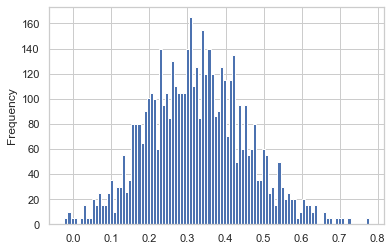

In [230]:
print("Average cosine similarity score:", stats_cos["cos_sim"].mean())
ax = stats_cos["cos_sim"].plot.hist(bins = 100)

So we have an average cosine similarity score of 0.3239, which is closer to 0, this indicates that the vectors are orthogonal and they share no similarity at all. But it is important to note that cosine similarity score looks for the meaning in the sentences and then tries to make vector representations and compares the embeddings.
But we have seen from the generated captions that the model actually generats good results, so the lower score doesn't neccessary reflect poor performance by the model. 
Although the generated captions are qualitatively good, their embeddings may not align closely with the averaged embeddings of all the reference captions. Since the reference captions tend to have similar meanings, their embeddings are more closely clustered, whereas the generated caption might use different phrasing or structure, leading to slight variations in its vector representation. As a result, the model is penalized, even if the generated output is reasonable.

Cosine similarity examples

In [171]:
max_index = stats_cos["cos_sim"].idxmax()
min_index = stats_cos["cos_sim"].idxmin()


print("Sample with highest Cosine similarity score:")
print("Predicted sentence:", stats_cos["preds"][max_index]) #predicted caption
print("Cosine similarity score:", stats_cos["cos_sim"][max_index]) #Cosine score
print("Reference captions:") 
for i in range(5):
    print(stats_cos["ref"][max_index][i])
print()


print("Sample with lowest Cosine similarity score:")
print("Predicted sentence:", stats_cos["preds"][min_index]) #predicted caption
print("Cosine similarity score:", stats_cos["cos_sim"][min_index]) #Cosine score
print("Reference captions:")
for i in range(5):
    print(stats_cos["ref"][min_index][i])

Sample with highest Cosine similarity score:
Predicted sentence: a <unk> <unk> with a lot of <unk> and <unk>
Cosine similarity score: 0.7767644762992859
Reference captions:
A suit case filled with a magazine and a pair of shoes.
An open suitcase on the ground, containing a pair of shoes and a magazine. 
Shoes and a magazine lie scattered inside an open suitcase.
An open suit case with a magazine and one show
A suitcase containing only a pair of shoes and a magazine.

Sample with lowest Cosine similarity score:
Predicted sentence: a horse is riding on a horse
Cosine similarity score: -0.023685164749622345
Reference captions:
A couple of horses hitched to bridles ready to travel.
A couple of large horses standing in the snow.
A bunch of horses standing around in the snow.
Horses in reigns huddle together on a snowy day.
A couple of brown horses standing next to each other.


So because cosine score looks for the vector representation of the captions, the generated caption with <unk> has more generic vector embedding which coincidentally alligns better with the reference caption's embeddings.
The predicted sentence with the lower score might be because the embedding for riding and standing are far away, or because cosine tries to find the meaning using a vector it's penalizing the generated one because the word riding implies active action while the reference captions imply the object being static.

In [177]:
# print(model_load.embed(torch.tensor(the_vocab.word2idx["horse"])))
# print(model_load.embed(torch.tensor(the_vocab.word2idx["riding"])))

Comparing BLEU and Cosine similarity

In [172]:
bleu_scores = stats_bleu["bleu"].tolist()
cosine_scores = stats_cos["cos_sim"].tolist()
cosine_scores_rescale = [(score + 1)/2 for score in cosine_scores]

avg_bleu_score = sum(bleu_scores) / len(bleu_scores)
avg_cosine_score = sum(cosine_scores_rescale) / len(cosine_scores_rescale)

print("Average BLEU score on test set: ", avg_bleu_score)
print("Average rescaled cosine similarity score on test set: ", avg_cosine_score)

Average BLEU score on test set:  0.5361574866473656
Average rescaled cosine similarity score on test set:  0.6619547160727307


So after scaling them they both have similar scores, but there is still room for improvement for the model

Analysis of individual examples

In [173]:
stats_3 = stats_bleu.copy()
stats_3["cos_sim"] = stats_cos["cos_sim"]
stats_3["score_diff"] = abs(stats_bleu["bleu"] - stats_cos["cos_sim"])
sorted_stats = stats_3.sort_values("score_diff", ascending = False)

In [174]:
similar_scores = sorted_stats[sorted_stats["score_diff"] < 0.1].iloc[[0]]
different_scores = sorted_stats[sorted_stats["score_diff"] > 0.5].iloc[[0]]

In [175]:
#where they give similar scores
print("Example with similar scores:")
print(f"Reference captions: {similar_scores['ref'].values[0]}")
print(f"Generated caption: {similar_scores['preds'].values[0]}")
print(f"BLEU score: {similar_scores['bleu'].values[0]:.2f}")
print(f"Cosine similarity score: {similar_scores['cos_sim'].values[0]:.2f}")

#where they dont give similar scores
print("Example with different scores:")
print(f"Reference captions: {different_scores['ref'].values[0]}")
print(f"Generated caption: {different_scores['preds'].values[0]}")
print(f"BLEU score: {different_scores['bleu'].values[0]:.2f}")
print(f"Cosine similarity score: {different_scores['cos_sim'].values[0]:.2f}")

Example with similar scores:
Reference captions: ['A multi colored train traveling past a small town.', 'a colorful train is on the tracks near some bushes', "a brightly colored train making it's way down the railroad track.", 'A train moving along a track during the day.', 'A multi-colored train going down train tracks. ']
Generated caption: a train traveling down a track in the middle of a city
BLEU score: 0.50
Cosine similarity score: 0.40
Example with different scores:
Reference captions: ['A woman walking on the tennis court with her racket. ', 'A woman holding a tennis racket in her hand.', 'female player walking with racquet and fist clenched at the US Open', 'A tennis player at the US open walking off the court.', 'A girl wearing a purple tennis outfit while holding a tennis racket walking by a guy. ']
Generated caption: a woman holding a tennis racket on a court
BLEU score: 1.00
Cosine similarity score: 0.25


So as we can see when they have similar scores, the generated caption is still gives a good prediction for the image.
When the scores are very different, we see that the geneerated caption is still a very good prediction for the image, the only reason BLEU score is higher because it doesn't care about the order of the generated words whereas Cosine tries to match the meaning in the captions and the vector embedding for the word court is probably not close because the refernce caption with the word court does not have the words woman, holding and racket. 

### Making a function, if needed in the future

In [226]:
def train(epoch, model, training_sample, train_losses, train_accuracies, optimizer, criterion):
    model.train()
    
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    for i, (features, captions, lengths) in enumerate(training_sample):
        optimizer.zero_grad() #reset the gradients every time
        
        output = model(features, captions, lengths)
        
        packed_targets = pack_padded_sequence(captions, lengths, batch_first = True)[0]
        
        loss = criterion(output,packed_targets) 
        
        loss.backward() #triggering backward
        
        optimizer.step() #updates the parameter
        
        train_loss += loss.item()
        
        predicted = output.argmax(dim = 1)  # Get the word with the highest probability
        train_correct += (predicted == packed_targets).sum().item()
        train_total += packed_targets.numel()
    
    train_loss /= len(training_sample)
    train_losses.append(train_loss)
    train_accuracy = train_correct / train_total * 100 
    train_accuracies.append(train_accuracy)
        
    print("Epoch [{}]: Training Loss: {:.2f}, Training Accuracy: {:.2f}%".format(epoch, train_loss, train_accuracy))

In [227]:
def validate(model, testing_sample, criterion, val_losses, val_accuracies):
    model.eval()
    
    val_loss= 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for i, (features, captions, lengths) in enumerate(testing_sample):
            output = model(features, captions, lengths)

            packed_targets = pack_padded_sequence(captions, lengths, batch_first = True)[0]
            loss = criterion(output, packed_targets)
            
            val_loss += loss.item()
            predicted = output.argmax(dim = 1)
            val_correct += (predicted == packed_targets).sum().item()
            val_total += packed_targets.numel()

    val_loss /= len(testing_sample)
    val_losses.append(val_loss)
    val_accuracy = val_correct / val_total * 100 
    val_accuracies.append(val_accuracy)
    
    print("Validation Loss: {:.2f}, Validation Accuracy: {:.2f}%".format(val_loss, val_accuracy))

In [228]:
def looop(model, epochs, training_sample, testing_sample, optimizer, criterion, losst, acct,  lossv, accv):
    for epoch in range(1, epochs + 1):
        train(epoch, model, training_sample, losst, acct, optimizer, criterion)
        validate(model, testing_sample, criterion, lossv, accv)
        
    plt.figure(figsize = (12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(losst, label = "Training Loss")
    plt.plot(lossv, label = "Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training & Validation Loss")

    plt.subplot(1, 2, 2)
    plt.plot(acct, label = "Training Accuracy")
    plt.plot(accv, label = "Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training & Validation Accuracy")

    plt.show()

Epoch [1]: Training Loss: 0.71, Training Accuracy: 85.80%
Validation Loss: 0.77, Validation Accuracy: 85.20%
Epoch [2]: Training Loss: 0.66, Training Accuracy: 86.33%
Validation Loss: 0.75, Validation Accuracy: 85.35%
Epoch [3]: Training Loss: 0.62, Training Accuracy: 86.75%
Validation Loss: 0.74, Validation Accuracy: 85.42%
Epoch [4]: Training Loss: 0.59, Training Accuracy: 87.16%
Validation Loss: 0.74, Validation Accuracy: 85.52%
Epoch [5]: Training Loss: 0.57, Training Accuracy: 87.53%
Validation Loss: 0.74, Validation Accuracy: 85.49%


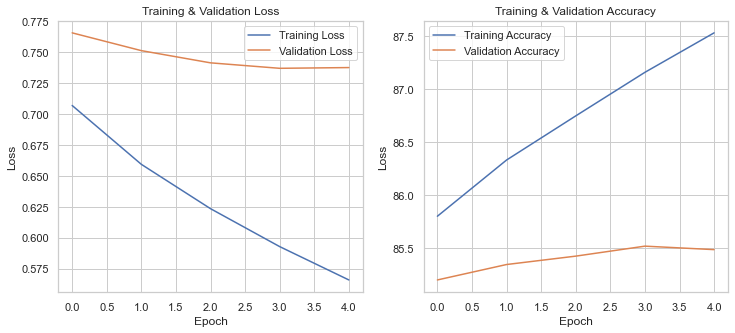

In [229]:
epochss = 5
criterionn = nn.CrossEntropyLoss()

params = list(decoder.parameters())
optimizerr = torch.optim.Adam(params, lr = 0.001)

lossmt, accmt = [],[]
lossmv, accmv = [],[]
looop(model = decoder, epochs = epochss, training_sample = train_loader, testing_sample = valid_loader,
      optimizer = optimizerr, criterion = criterionn, losst = lossmt, acct = accmt, lossv = lossmv, accv = accmv)